<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/aburdenko/gcp-jupyter-notebooks/blob/master/vertex-pipelines/vertex_pipelines_pandas.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://nbviewer.jupyter.org/github/aburdenko/gcp-jupyter-notebooks/blob/main/vertex-pipelines/vertex_pipelines_pandas.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
    <td><a target="_blank"  href="https://colab.sandbox.google.com/github/aburdenko/gcp-jupyter-notebooks/blob/main/vertex-pipelines/vertex_pipelines_pandas.ipynb"><img width=26px src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
    <td><a target="_blank"  href="https://console.cloud.google.com/vertex-ai/workbench/list/instances"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/a/a0/Google_Cloud_Workbench.png" /> Run in Google Cloud Vertex Workbench</a></td>
</table>


Based on [Colab Notebooks](https://console.cloud.google.com/marketplace/product/colab-marketplace-image-public/colab) available in GCP Marketplace.

# Authentication and Authorization

In [ ]:
!pip3 install kfp

     |████████████████████████████████| 296 kB 10.2 MB/s 
     |████████████████████████████████| 127 kB 42.6 MB/s 
     |████████████████████████████████| 636 kB 33.5 MB/s 
     |████████████████████████████████| 105 kB 53.4 MB/s 
     |████████████████████████████████| 1.6 MB 58.6 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 87 kB 5.5 MB/s 
     |████████████████████████████████| 10.1 MB 26.9 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for kfp: filename=kfp-1.8.9-py3-none-any.whl size=409653 sha256=cfe91beaff7681d83f0d46930e6197a5a76fdacf86cab2cd0096a

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving aburdenko-project-e727091c7641.json to aburdenko-project-e727091c7641.json
User uploaded file "aburdenko-project-e727091c7641.json" with length 2318 bytes


In [ ]:
import os

# Imports Credential File:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "aburdenko-project-e727091c7641.json"
print("Service Account Key: {}".format(os.environ["GOOGLE_APPLICATION_CREDENTIALS"]))

Service Account Key: aburdenko-project-e727091c7641.json


In [78]:
USER = "aburdenko@google.com" # @param {type:"string"} <---CHANGE THESE
BUCKET_NAME = "vertex-ai-training-bucket" # @param {type:"string"} <---CHANGE THESE
GOOGLE_CLOUD_PROJECT = "aburdenko-project" # @param {type:"string"} <---CHANGE THESE
REGION = "us-central1" # @param {type:"string"} <---CHANGE THESE
#REGION = "us-east4"
SERVICE_ACCOUNT="653488387759-compute@developer.gserviceaccount.com" #@param {type:"string"} <---CHANGE THESE

PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)
PIPELINE_ROOT
# %%


'vertex-ai-training-bucket/pipeline_root/aburdenko@google.com'

In [ ]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

Authenticated


In [79]:
%env GOOGLE_CLOUD_PROJECT=$GOOGLE_CLOUD_PROJECT
!echo $GOOGLE_CLOUD_PROJECT
!gcloud config set project $GOOGLE_CLOUD_PROJECT

env: GOOGLE_CLOUD_PROJECT=aburdenko-project
aburdenko-project
Updated property [core/project].


In [ ]:
!gcloud --project $GOOGLE_CLOUD_PROJECT services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com

Operation "operations/acf.p2-653488387759-fc0d8938-fbf6-485d-ac5a-049fbd451ca8" finished successfully.


In [ ]:
from inspect import isdatadescriptor
from typing import NamedTuple

from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import component
from kfp.v2.google.client import AIPlatformClient


In [ ]:
from google.cloud.bigquery import magics
import google.auth
credentials, project = google.auth.default()

magics.context.credentials = credentials
# SERVICE_ACCOUNT = (
#     "653488387759-compute@developer.gserviceaccount.com"  # <--- CHANGE THIS         
# )

# Connect to BigQuery

In [83]:
%reload_ext google.cloud.bigquery

Use the storage API for best performance

In [84]:
%%bigquery tax_forms --use_bqstorage_api
SELECT * FROM `bigquery-public-data.irs_990.irs_990_2012`


In [85]:
tax_forms.head()


,ein,tax_pd,subseccd,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,royaltsinc,grsrntsreal,grsrntsprsnl,rntlexpnsreal,rntlexpnsprsnl,rntlincreal,rntlincprsnl,netrntlinc,grsalesecur,grsalesothr,cstbasisecur,cstbasisothr,gnlsecur,gnlsothr,netgnls,grsincfndrsng,lessdirfndrsng,netincfndrsng,grsincgaming,lessdirgaming,netincgaming,grsalesinvent,lesscstofgoods,netincsales,miscrevtot11e,totrevenue,compnsatncurrofcr,othrsalwages,payrolltx,profndraising,totfuncexpns,totassetsend,txexmptbndsend,secrdmrtgsend,unsecurednotesend,totliabend,retainedearnend,totnetassetend,nonpfrea,gftgrntsrcvd170,txrevnuelevied170,srvcsval170,grsinc170,grsrcptsrelated170,totgftgrntrcvd509,grsrcptsadmissn509,txrevnuelevied509,srvcsval509,subtotsuppinc509,totsupp509
0,204122653,200412,07,N,0,0,0,0,0,92545,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2075,2578,-503,0,92071,0,0,0,0,92105,23511,0,0,0,0,23511,23511,00,0,0,0,0,0,0,0,0,0,0,0
1,943197474,200512,03,N,0,0,0,0,0,5672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5672,0,0,0,0,2043,283366,0,0,0,2800,0,280566,13,0,0,0,0,0,0,0,0,0,0,0
2,204774976,200604,03,N,0,0,0,0,0,115339,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,115386,0,0,0,0,116723,4663,0,0,0,6000,0,-1337,07,0,0,0,0,0,0,0,0,0,0,0
3,330227205,200612,03,N,0,0,0,0,4200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4200,0,0,0,0,4000,50,0,0,0,0,0,50,00,0,0,0,0,0,0,0,0,0,0,0
4,364418787,200612,03,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,07,305045,0,0,0,0,0,0,0,0,0,0


In [100]:
@component(
    output_component_file="hw.yaml"
    , base_image="python:3.9"
    , packages_to_install=["google-cloud-bigquery","pandas","pyarrow"])
def load_table(query: str) -> str:
    from google.cloud import bigquery    
    import os
    google_cloud_project=GOOGLE_CLOUD_PROJECT
    client = bigquery.Client(project=google_cloud_project)    
    df = client.query(query).to_dataframe()    
    return df.head(100).to_csv()

In [101]:
@component(packages_to_install=["google-cloud-storage"])
def two_outputs(
    text: str,
) -> NamedTuple(
    "Outputs",
    [
        ("output_one", str),  # Return parameters
        ("output_two", str),
    ],
):
    # the import is not actually used for this simple example, but the import
    # is successful, as it was included in the `packages_to_install` list.
    from google.cloud import storage  # noqa: F401

    o1 = f"output one from text: {text}"
    o2 = f"output two from text: {text}"
    print("output one: {}; output_two: {}".format(o1, o2))
    return (o1, o2)


In [102]:
@component(packages_to_install=["google-cloud-storage", "google-cloud-bigquery", "pandas"])
def consumer(df_str: str, text2: str, text3: str):
 
    print(f"text1: {df_str}; text2: {text2}; text3: {text3}")
    from google.cloud import storage  # noqa: F401

    client = storage.Client()    
    bucket = client.get_bucket(BUCKET_NAME)    
    d=bucket.blob('upload_test/test.csv')
    d.upload_from_string(df_str)


In [103]:
@dsl.pipeline(
    name="hello-world-v2",
    description="A simple intro pipeline",
    pipeline_root=PIPELINE_ROOT,
)
def intro_pipeline(query: str = "SELECT * FROM `bigquery-public-data.irs_990.irs_990_2012`"):
    load_table_task = load_table(query)
    two_outputs_task = two_outputs(query)
    consumer_task = consumer(  
        load_table_task.output,
        two_outputs_task.outputs["output_one"],
        two_outputs_task.outputs["output_two"],
    )

from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=intro_pipeline, package_path="hw_pipeline_job.json"
)


/usr/local/lib/python3.7/dist-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


In [104]:
from datetime import datetime
# from google.cloud import aiplatform
# from google.cloud.aiplatform import pipeline_jobs


api_client = AIPlatformClient(
    project_id=GOOGLE_CLOUD_PROJECT,
    region=REGION,
)

PIPELINE_SPEC_PATH="custom_train_pipeline.json"
PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(BUCKET_NAME, USER)

compiler.Compiler().compile(
   pipeline_func=intro_pipeline, package_path=PIPELINE_SPEC_PATH
)
api_client = AIPlatformClient(project_id=GOOGLE_CLOUD_PROJECT, region=REGION)
response = api_client.create_run_from_job_spec(
 PIPELINE_SPEC_PATH,
 pipeline_root=PIPELINE_ROOT
)

/usr/local/lib/python3.7/dist-packages/kfp/v2/google/client/client.py:173: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  category=FutureWarning,
/usr/local/lib/python3.7/dist-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


Result sholud look something like this:

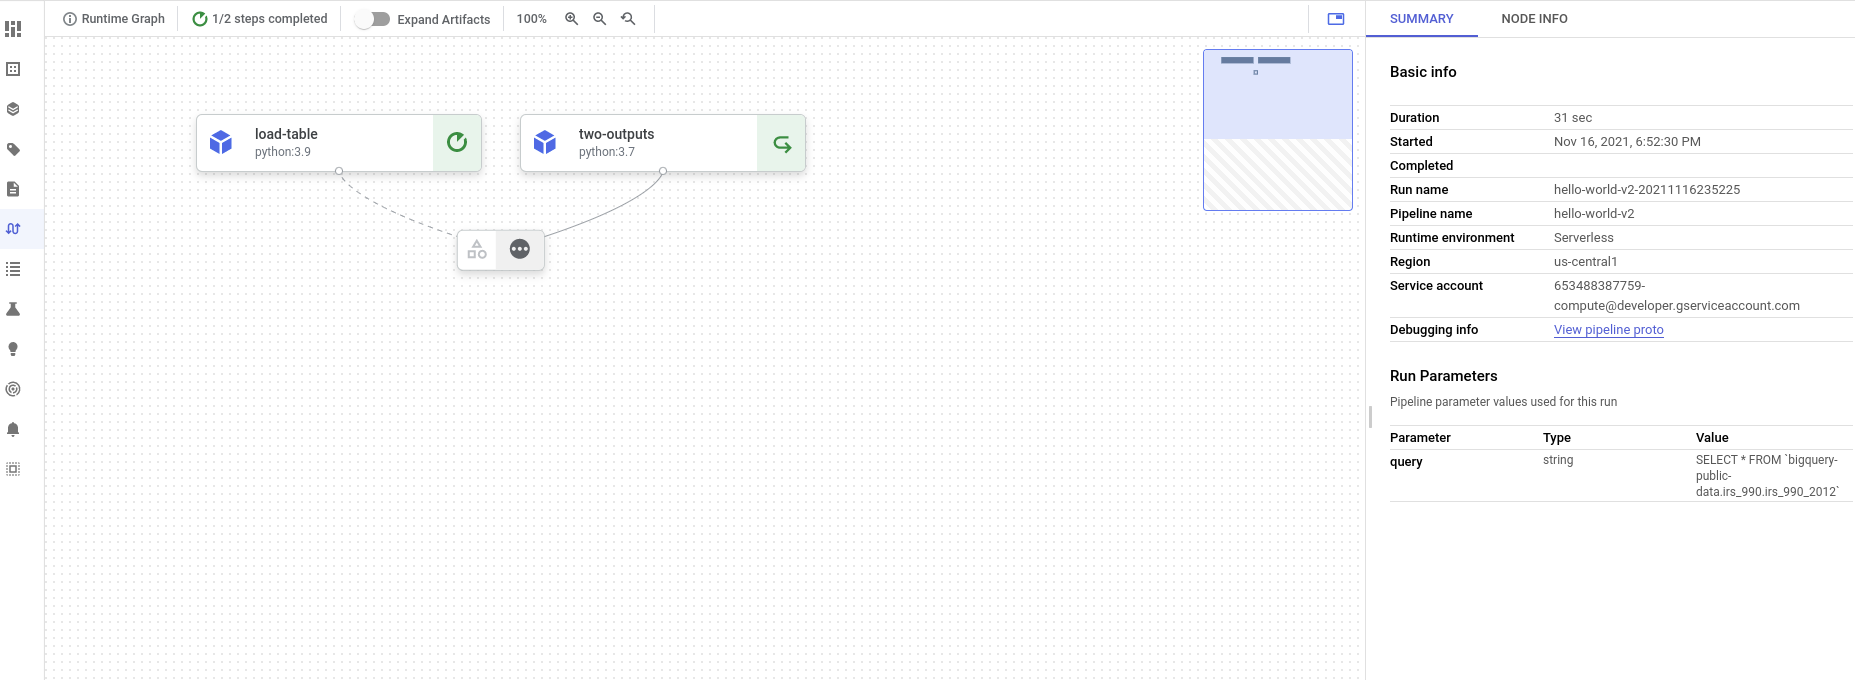

# Create Scikit Learn Model to predict XXX

# Show Model Lineage (Vertex Metadata)